# **Importing from xl "ib77" to get "df_mf_ib77_nn_s"  & xl "ib97" to get "df_mf_ib97_nn_s"** 

# Set up

In [95]:
import sys
print(sys.executable)
print("note: THIS IS THE DIRECTORY PYTHON IS WORKING IN.")

/home/bhuns/miniconda3/bin/python
note: THIS IS THE DIRECTORY PYTHON IS WORKING IN.


In [96]:
# Imports required for Loading, sorting .csx files to create specific data sets ie mrn inbody readings. 
%run ./sys_funcs.py              # loads all the def functions in sys_funcs.py into memory
#import sys_funcs                 # gives access to these def function digitalform that are in memory
from pathlib import Path
import csv
import pandas as pd
import numpy as np
import tkinter as tk
import pickle
from pathlib import Path
import csv
import os
import sys
from datetime import datetime
from datetime import time
from sys_funcs import read_csv_to_array
from sys_funcs import clean_wsl_path
from sys_funcs import array_to_dt_row_dict
from sys_funcs import make_blnk_update_row_dict
from sys_funcs import transpose_csv_to_col_dict
#from sys_funcs import update_values_with_config, get_update_result
from sys_funcs import transfer_updates
from sys_funcs import get_dtv_range
from sys_funcs import universal_import
from sys_funcs import parse_inbody_timestamp
from sys_funcs import build_lut
from sys_funcs import extract_a_column_as_df
from sys_funcs import extract_multicolumns_as_df
from sys_funcs import validate_and_sort_timestamps
from sys_funcs import extract_and_filter_by_time_window
from sys_funcs import read_file_dual_path
from sys_funcs import write_file_dual_path
from sys_funcs import asc_to_csv_cnv
from collections.abc import Mapping
import re
#from sys_funcs import 

In [97]:
# set print rows  This worksheet sets maximum # of rows printed
pd.set_option('display.max_rows', 1000)  # Adjust the number of rows to display
# pd.reset_option('display.max_rows')  
print('print set to 1000 rows max' )

print set to 1000 rows max


In [98]:
print("NOTE: timestamp = Test Date / Time does not work  use computed time stamp")

NOTE: timestamp = Test Date / Time does not work  use computed time stamp


# Def functions called in data importing & refinment.

In [99]:
media_lst = [
    "timestamp",
    "dtv",
    "ib_id",
    "cls",
    "cmmnts"
]

In [100]:
# 3rd version def drop_duplicates_by_test_time(df, keep='first', log=True):
def drop_duplicates_by_test_time(df, keep='first', log=True):
    """
    Removes duplicate rows based on the 'Test Date / Time' column.
    Keeps only the first (or last) occurrence.
    """
    df = df.copy()

    # Identify duplicate timestamps (beyond the one we keep)
    dupes = (
        df.loc[df.duplicated(subset=['Test Date / Time'], keep=keep), 'Test Date / Time']
        .astype(str)
        .values
        .tolist()
    )

    # Drop duplicate rows
    df = df.drop_duplicates(subset=['Test Date / Time'], keep=keep)

    # Optional logging
    if log and dupes:
        print("Removed duplicate rows for timestamps:", dupes)

    return df


In [101]:
# def strip_numbers_from_columns(df):
import re

def strip_numbers_from_columns(df):
    """
    Removes leading/trailing numbers and any leftover separators
    so that cases like '1.0ID' become 'ID'.
    """
    df = df.copy()
    new_cols = {}

    for col in df.columns:
        cleaned = col

        # Remove leading numbers + separators
        cleaned = re.sub(r'^\d+[\s\-\_\.:]*', '', cleaned)

        # Remove trailing numbers + separators
        cleaned = re.sub(r'[\s\-\_\.:]*\d+$', '', cleaned)

        # Remove leftover leading/trailing punctuation (.,-_:) after number removal
        cleaned = re.sub(r'^[\.\-\_\:]+', '', cleaned)
        cleaned = re.sub(r'[\.\-\_\:]+$', '', cleaned)

        new_cols[col] = cleaned

    return df.rename(columns=new_cols)


In [102]:
# Use drop duplicate function If duplicates are found
def drop_duplicate_columns(df, keep='first', log=True):
    """
    Removes duplicate column names from a DataFrame, keeping only the first
    (or last) occurrence. Useful after column-cleaning steps that may cause
    collisions. good i'm moving this around because I want to go ahead and do the I'm talking too

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame.
    keep : {'first', 'last'}, default 'first'
        Which duplicate to keep.
    log : bool, default True
        Whether to print which columns were removed.

    Returns
    -------
    pandas.DataFrame
        DataFrame with duplicate columns removed.
    """
    df = df.copy()

    # Identify duplicates beyond the one we keep
    dupes = df.columns[df.columns.duplicated(keep=keep)].tolist()

    # Drop them
    df = df.loc[:, ~df.columns.duplicated(keep=keep)]

    # Optional logging
    if log and dupes:
        print("Removed duplicate columns:", dupes)

    return df


In [103]:
# def prepend_empty_columns(df, col_list):
def prepend_empty_columns(df, col_list):
    """
    Prepend empty columns (from col_list) to the front of df.
    Returns a new DataFrame.
    """
    import pandas as pd

    # Create empty columns with same row count
    empty_df = pd.DataFrame(
        {col: [None] * len(df) for col in col_list}
    )

    # Prepend them
    return pd.concat([empty_df, df], axis=1)


In [104]:
# revised def fill_ib_media_cols(df):
def fill_ib_media_cols(df):
    df = df.copy()

    # --- 1. Clean and parse timestamp --------------------------
    def fix_ts(x):
        if pd.isna(x):
            return np.nan
        # Convert float → int safely
        try:
            x_int = int(float(x))
        except:
            return np.nan
        # Zero‑pad to 14 digits (YYYYMMDDHHMMSS)
        s = str(x_int).zfill(14)
        return pd.to_datetime(s, format="%Y%m%d%H%M%S", errors="coerce")

    df['timestamp'] = df['Test Date / Time'].apply(fix_ts)

    # --- 2. dtv ------------------------------------------------
    origin = pd.Timestamp("1900-01-01")
    df['dtv'] = (df['timestamp'] - origin).dt.days

    # --- 3. ib_id ----------------------------------------------
    def classify_ib_id(ts):
        if pd.isna(ts):
            return np.nan
        hour = ts.hour
        return "mrn" if 3 <= hour <= 12 else "eve"

    df['ib_id'] = df['timestamp'].apply(classify_ib_id)

    # --- 4–5. cls, cmmnts --------------------------------------
    df['cls'] = np.nan
    df['cmmnts'] = np.nan

    return df


In [105]:
# Sort the rows by timestamp
def sort_by_timestamp(df):
    """
    Sorts an InBody dataframe by the 'timestamp' column
    in ascending chronological order.
    """
    df = df.copy()
    df = df.sort_values(by='timestamp', ascending=True)
    df = df.reset_index(drop=True)
    return df


In [106]:
# A function to combine frames of IB77 with IB97 and sorting into one data frame. N
# this will be used on a column by column basis for a list of columns.
def combine_weight_frames(df_a, df_b, ts_col="timestamp", wt_a="2. wt", wt_b="4. wt"):
    """
    Combines two dataframes with different weight column names into a single
    dataframe with columns: timestamp, wt, sorted by timestamp.

    Parameters
    ----------
    df_a : pd.DataFrame
        First dataframe containing a timestamp column and a weight column.
    df_b : pd.DataFrame
        Second dataframe containing a timestamp column and a weight column.
    ts_col : str, optional
        Name of the timestamp column (default 'timestamp').
    wt_a : str, optional
        Weight column name in df_a (default '2. wt').
    wt_b : str, optional
        Weight column name in df_b (default '4. wt').

    Returns
    -------
    pd.DataFrame
        Combined dataframe with columns: timestamp, wt, sorted by timestamp.
    """

    # Normalize df_a
    df_a_norm = df_a[[ts_col, wt_a]].rename(columns={wt_a: "wt"})

    # Normalize df_b
    df_b_norm = df_b[[ts_col, wt_b]].rename(columns={wt_b: "wt"})

    # Stack them vertically
    df_combined = pd.concat([df_a_norm, df_b_norm], ignore_index=True)

    # Sort by timestamp
    df_combined = df_combined.sort_values(by=ts_col).reset_index(drop=True)

    return df_combined


In [107]:
# remove duplicates on the basis of timestamp
def remove_ib_duplicates(df, subset_cols=None):
    """
    Removes duplicate InBody rows based on key identifying columns.
    Default behavior: remove duplicates based on ['ID', 'timestamp'].
    """
    df = df.copy()

    # Default duplicate definition
    if subset_cols is None:
        subset_cols = ['timestamp']
        # subset_cols = ['ID', 'timestamp']
    # Remove duplicates, keeping the first occurrence
    df = df.drop_duplicates(subset=subset_cols, keep='first')

    # Reset index for cleanliness
    df = df.reset_index(drop=True)

    return df


In [108]:
# veirfy if rows exixt in master_timestamps(df_master, df_new, ts_col="timestamp"):
def filter_new_rows_by_master_timestamps(df_master, df_new, ts_col="timestamp"):
    """
    Filters df_new so that only rows whose timestamps appear in df_master remain.

    Parameters
    ----------
    df_master : pd.DataFrame
        The master dataframe containing valid timestamps.
    df_new : pd.DataFrame
        The new dataframe to be filtered.
    ts_col : str, optional
        The name of the timestamp column (default is 'timestamp').

    Returns
    -------
    pd.DataFrame
        A filtered version of df_new containing only rows whose timestamps
        exist in df_master.
    """

    # Extract the set of valid timestamps from the master dataframe
    valid_timestamps = set(df_master[ts_col])

    # Filter df_new to keep only rows with timestamps in the master set
    df_filtered = df_new[df_new[ts_col].isin(valid_timestamps)].copy()

    return df_filtered


In [109]:
# def keep_only_new_timestamps(df_master, df_new, ts_col="timestamp")
def keep_only_new_timestamps(df_master, df_new, ts_col="timestamp"):
    """
    Returns only the rows in df_new whose timestamps do NOT exist in df_master.

    Parameters
    ----------
    df_master : pd.DataFrame
        The master dataframe containing timestamps already ingested.
    df_new : pd.DataFrame
        The new dataframe to be filtered.
    ts_col : str, optional
        The name of the timestamp column (default is 'timestamp').

    Returns
    -------
    pd.DataFrame
        A filtered version of df_new containing only rows with timestamps
        NOT present in df_master.
    """

    # Extract the set of timestamps already in the master
    existing_ts = set(df_master[ts_col])

    # Keep only rows whose timestamp is NOT in the master
    df_filtered = df_new[~df_new[ts_col].isin(existing_ts)].copy()

    return df_filtered


In [110]:
# def append_rows_with_master_schema(master_df, adder_df):
import pandas as pd
import numpy as np

def append_rows_with_master_schema(master_df, adder_df):
    """
    Appends rows from adder_df into master_df while enforcing the master_df schema.

    For each row in adder_df:
      - Columns that exist in adder_df are copied.
      - Columns missing from adder_df are filled with NaN.
      - All master_df columns are preserved in order.

    Parameters
    ----------
    master_df : pd.DataFrame
        The master dataframe with the full schema.
    adder_df : pd.DataFrame
        The dataframe containing rows to append (subset of master columns).

    Returns
    -------
    pd.DataFrame
        Updated master_df with new rows appended.
    """

    # Reindex adder_df to match master_df columns, filling missing columns with NaN
    adder_aligned = adder_df.reindex(columns=master_df.columns)

    # Append and return
    return pd.concat([master_df, adder_aligned], ignore_index=True)


In [111]:
# def filter_by_value(df, column, value):
def filter_by_value(df, column, value):
    """
    Returns a filtered DataFrame containing only rows where df[column] == value.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to filter.
    column : str
        The column name to filter on.
    value : any
        The value that the column must match.

    Returns
    -------
    pd.DataFrame
        A filtered dataframe containing only matching rows.
    """
    return df[df[column] == value].copy()


In [112]:
# def write_df_to_pickle(df, filename):
def write_df_to_pickle(df, filename):
    """
    Writes a DataFrame to a pickle file.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to save.
    filename : str
        The pickle filename, e.g. 'mydata.pkl'.
    """
    df.to_pickle(filename)

# usage 
# write_df_to_pickle(df, "df.pkl")


In [113]:
# def load_df_from_pickle(filename):

def load_df_from_pickle(filename):
    """
    Loads a DataFrame from a pickle file.

    Parameters
    ----------
    filename : str
        Path to the pickle file.

    Returns
    -------
    pd.DataFrame
    """
    return pd.read_pickle(filename)

    # usage 
    # df = load_df_from_pickle("df.pkl")



In [114]:
# def scale_mean_to_one(series):
def scale_mean_to_one(series):
    """Scale a Pandas Series so that its mean becomes 1."""
    mean_val = series.mean()
    return series / mean_val


In [115]:
# def plot_column(df, col_name):
import matplotlib.pyplot as plt

def plot_column(df, col_name):
    """
    Plot a single column from a dataframe.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the column.
    col_name : str
        The name of the column to plot.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(df[col_name], marker='o', linestyle='-', linewidth=1)
    plt.title(f"{col_name} over index")
    plt.xlabel("Index")
    plt.ylabel(col_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Import new data from ip77 in the data folder of repo and results =  "df_mf_ib77_nn_s"

## Creating "df_mf_ib77_nn_s"

### This segment imports the data from the Excel file probo/data/ib77 to dataframe with numbers in col names

In [116]:
# loads the new from the 770
df_ib77_raw = universal_import(
    folder_path="/home/bhuns/JL_2/data/ib77",
    pattern="*"
)
# verify df_ib77_raw #print("df_ib77_raw w/o numbers OK")

✅ Loaded 091725_20251225081906.csv with utf-8
✅ Loaded 091725_20251230231705.csv with utf-8
✅ Loaded 091725_20251213054921.csv with utf-8
✅ Loaded 091725_20251214234814.csv with utf-8
✅ Loaded 091725_20251229081757.csv with utf-8
✅ Loaded 091725_20251223231059.csv with utf-8
✅ Loaded 091725_20260102235527.csv with utf-8
✅ Loaded 091725_20251231082459.csv with utf-8
✅ Loaded 091725_20251217075000.csv with utf-8
✅ Loaded 091725_20251218081604.csv with utf-8
✅ Loaded 091725_20251221071026.csv with utf-8
✅ Loaded 091725_20260105233732.csv with utf-8
✅ Loaded 091725_20251216233809.csv with utf-8
✅ Loaded 091725_20251215080038.csv with utf-8
✅ Loaded 091725-1_20251212221713.csv with utf-8
✅ Loaded 091725_20251219080729.csv with utf-8
✅ Loaded 091725_20251221205127.csv with utf-8
✅ Loaded 091725_20251226083412.csv with utf-8
✅ Loaded 091725_20251227083952.csv with utf-8
✅ Loaded 091725_20251214090336.csv with utf-8
✅ Loaded 091725_20251230083221.csv with utf-8
✅ Loaded 091725_20260102083939.c

In [117]:
df_ib77_raw.columns

Index(['1. Name', '2. ID', '3. Height', '4. Date of Birth', '5. Age',
       '6. Mobile Number', '7. Phone Number', '8. Zip Code', '9. Address',
       '10. E-mail',
       ...
       '143. R/Ht', '144. Xc/Ht', '145. HGS of Left Arm 1st',
       '146. HGS of Left Arm 2nd', '147. HGS of Right Arm 1st',
       '148. HGS of Right Arm 2nd', '149. HGS/WT', 'Unnamed: 149',
       'source_file', 'encoding_used'],
      dtype='object', length=152)

In [118]:
list(df_ib77_raw.columns)

['1. Name',
 '2. ID',
 '3. Height',
 '4. Date of Birth',
 '5. Age',
 '6. Mobile Number',
 '7. Phone Number',
 '8. Zip Code',
 '9. Address',
 '10. E-mail',
 '11. Date of Registration',
 '12. Memo',
 '13. Test Date / Time',
 '14. Weight',
 '15. TBW (Total Body Water)',
 '16. ICW (Intracellular Water)',
 '17. ECW (Extracellular Water)',
 '18. DLM (Dry Lean Mass)',
 '19. BFM (Body Fat Mass)',
 '20. LBM (Lean Body Mass)',
 '21. SMM (Skeletal Muscle Mass)',
 '22. BMI (Body Mass Index)',
 '23. PBF (Percent Body Fat)',
 '24. LBM of Right Arm',
 '25. LBM% of Right Arm',
 '26. LBM of Left Arm',
 '27. LBM% of Left Arm',
 '28. LBM of Trunk',
 '29. LBM% of Trunk',
 '30. LBM of Right Leg',
 '31. LBM% of Right Leg',
 '32. LBM of Left Leg',
 '33. LBM% of Left Leg',
 '34. Leg Lean Mass',
 '35. TBW of Right Arm',
 '36. TBW of Left Arm',
 '37. TBW of Trunk',
 '38. TBW of Right Leg',
 '39. TBW of Left Leg',
 '40. ICW of Right Arm',
 '41. ICW of Left Arm',
 '42. ICW of Trunk',
 '43. ICW of Right Leg',
 '44

In [119]:
df_ib77_raw

,1. Name,2. ID,3. Height,4. Date of Birth,5. Age,6. Mobile Number,7. Phone Number,8. Zip Code,9. Address,10. E-mail,...,143. R/Ht,144. Xc/Ht,145. HGS of Left Arm 1st,146. HGS of Left Arm 2nd,147. HGS of Right Arm 1st,148. HGS of Right Arm 2nd,149. HGS/WT,Unnamed: 149,source_file,encoding_used
0,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251225081906.csv,utf-8
1,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251230231705.csv,utf-8
2,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251213054921.csv,utf-8
3,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251214234814.csv,utf-8
4,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251229081757.csv,utf-8
5,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251223231059.csv,utf-8
6,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20260102235527.csv,utf-8
7,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251231082459.csv,utf-8
8,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251217075000.csv,utf-8
9,91725,6ft 06.0in,1939.02.23.,F,86.0,-,-,-,-,-,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251218081604.csv,utf-8


### This segment strips off the col names of numbers and produces "df_m_ib77_nn" and demonstrates slicing

In [120]:
df_ib77_nn = strip_numbers_from_columns(df_ib77_raw)
#verify print(list(df_ib77_nn.columns))

In [121]:
# verify slicing df_ib77_nn[['ID','Test Date / Time','ECW/TBW']]  
#,"SMM (Skeletal Muscle Mass)" , "Weight" , "BMR (Basal Metabolic Rate)" , "ECW/TBW"]].head(20)

In [122]:
df_ib77_nn_s = df_ib77_nn.sort_values(by="Test Date / Time").reset_index(drop=True)

In [123]:
df_ib77_nn_s[['ID','Test Date / Time','ECW/TBW']]

,ID,Test Date / Time,ECW/TBW
0,6ft 06.0in,20251211092610,0.410
1,6ft 06.0in,20251212084231,0.409
2,6ft 06.0in,20251212221713,0.415
3,6ft 06.0in,20251213054921,0.410
4,6ft 06.0in,20251214090336,0.407
5,6ft 06.0in,20251214234814,0.414
6,6ft 06.0in,20251215080038,0.406
7,6ft 06.0in,20251215233324,0.413
8,6ft 06.0in,20251216064808,0.406
9,6ft 06.0in,20251216233809,0.411


### This segment adds **media_cols** and fills them from data in the results **"df_m_ib77_nn"**

In [124]:
df_m_ib77_nn = prepend_empty_columns(df_ib77_nn, media_lst)
# verify df_m_ib77_nn

In [125]:
# fill_ib_media_cols(df_mf_ib77_nn)
df_mf_ib77_nn = fill_ib_media_cols(df_m_ib77_nn)
# verify df_mf_ib77_nn

### This segment eliminates "COL" duplicates in **df_mf_ib77_nn**

In [126]:
df_mf_ib77_nn = drop_duplicate_columns(df_mf_ib77_nn)
print ("df_mf_ib77_nn , No numbers, no duplicates OK")

Removed duplicate columns: ['Systolic', 'Diastolic', 'Pulse', 'Mean Artery Pressure', 'Pulse Pressure', 'Rate Pressure Product']
df_mf_ib77_nn , No numbers, no duplicates OK


### This segment sorts "df_mf_ib77_nn" to get "df_mf_ib77_nn_s"

In [127]:
df_mf_ib77_nn_s = sort_by_timestamp(df_mf_ib77_nn )
# verify df_mf_ib77_nn_s

### This segment eliminates "ROW" duplicates based on **"test_time" in **"df_mf_ib77_nn"** note: "mf" means media added and filled]

In [128]:
df_mf_ib77_nn_s = df_mf_ib77_nn_s.drop_duplicates(subset="timestamp", keep="first")
print("No timestamp duplicates **df_mf_ib77_nn** detected")

No timestamp duplicates **df_mf_ib77_nn** detected


In [129]:
# verify list(df_mf_ib77_nn_s.columns)

# Set the "plt_lst" [the list ov cols to be plotted]
1. **"df_mf_ib77_nn_s"** is the source data 

In [130]:
plt_lst = list["ECW/TBW", 'BMR (Basal Metabolic Rate)',"SMM (Skeletal Muscle Mass)",'VFA (Visceral Fat Area)']
# verify plt_lst

In [131]:
# verify 
df_mf_ib77_nn_s 

,timestamp,dtv,ib_id,cls,cmmnts,Name,ID,Height,Date of Birth,Age,...,R/Ht,Xc/Ht,HGS of Left Arm 1st,HGS of Left Arm 2nd,HGS of Right Arm 1st,HGS of Right Arm 2nd,HGS/WT,Unnamed,source_file,encoding_used
0,2025-12-11 09:26:10,46000,mrn,NaN,NaN,251211-1,6ft 06.0in,1939.02.23.,M,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251211092610.csv,utf-8
1,2025-12-12 08:42:31,46001,mrn,NaN,NaN,251211-1,6ft 06.0in,1939.02.23.,M,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251212084231.csv,utf-8
2,2025-12-12 22:17:13,46001,eve,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251212221713.csv,utf-8
3,2025-12-13 05:49:21,46002,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251213054921.csv,utf-8
4,2025-12-14 09:03:36,46003,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251214090336.csv,utf-8
5,2025-12-14 23:48:14,46003,eve,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251214234814.csv,utf-8
6,2025-12-15 08:00:38,46004,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251215080038.csv,utf-8
7,2025-12-15 23:33:24,46004,eve,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251215233324.csv,utf-8
8,2025-12-16 06:48:08,46005,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251216064808.csv,utf-8
9,2025-12-16 23:38:09,46005,eve,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251216233809.csv,utf-8


In [132]:
# Selects the cols to be plotted 
plt_lst = ["ECW/TBW", 'BMR (Basal Metabolic Rate)',"SMM (Skeletal Muscle Mass)",'VFA (Visceral Fat Area)']
df_mf_ib77_nn_s[["timestamp",'ib_id']+plt_lst]

,timestamp,ib_id,ECW/TBW,BMR (Basal Metabolic Rate),SMM (Skeletal Muscle Mass),VFA (Visceral Fat Area)
0,2025-12-11 09:26:10,mrn,0.410,2158,99.4,167.0
1,2025-12-12 08:42:31,mrn,0.409,2186,101.2,162.7
2,2025-12-12 22:17:13,eve,0.415,2208,101.6,158.6
3,2025-12-13 05:49:21,mrn,0.410,2203,102.3,159.8
4,2025-12-14 09:03:36,mrn,0.407,2148,99.2,167.3
5,2025-12-14 23:48:14,eve,0.414,2160,99.2,163.1
6,2025-12-15 08:00:38,mrn,0.406,2155,99.9,166.8
7,2025-12-15 23:33:24,eve,0.413,2230,103.4,153.1
8,2025-12-16 06:48:08,mrn,0.406,2129,98.3,167.5
9,2025-12-16 23:38:09,eve,0.411,2141,98.3,166.4


In [133]:
# This filters out only the morning values of chosen data Col
df_mf_ib77_nn_s_mrn = filter_by_value(df_mf_ib77_nn_s, 'ib_id', "mrn")
# verify 
df_mf_ib77_nn_s_mrn

,timestamp,dtv,ib_id,cls,cmmnts,Name,ID,Height,Date of Birth,Age,...,R/Ht,Xc/Ht,HGS of Left Arm 1st,HGS of Left Arm 2nd,HGS of Right Arm 1st,HGS of Right Arm 2nd,HGS/WT,Unnamed,source_file,encoding_used
0,2025-12-11 09:26:10,46000,mrn,NaN,NaN,251211-1,6ft 06.0in,1939.02.23.,M,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251211092610.csv,utf-8
1,2025-12-12 08:42:31,46001,mrn,NaN,NaN,251211-1,6ft 06.0in,1939.02.23.,M,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251212084231.csv,utf-8
3,2025-12-13 05:49:21,46002,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251213054921.csv,utf-8
4,2025-12-14 09:03:36,46003,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251214090336.csv,utf-8
6,2025-12-15 08:00:38,46004,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251215080038.csv,utf-8
8,2025-12-16 06:48:08,46005,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251216064808.csv,utf-8
10,2025-12-17 07:50:00,46006,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251217075000.csv,utf-8
12,2025-12-18 08:16:04,46007,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251218081604.csv,utf-8
14,2025-12-19 08:07:29,46008,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251219080729.csv,utf-8
16,2025-12-20 08:50:24,46009,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251220085024.csv,utf-8


In [134]:
write_df_to_pickle(df_mf_ib77_nn_s, "df_mf_ib77_nn_s_mrn.pkl")
print("df_mf_ib77_nn_s_mrn written to pickle")

df_mf_ib77_nn_s_mrn written to pickle


# Normalize and subract 1 on "df_mf_ib77_nn_s[plt_lst]" col by col

In [142]:
# df_mf_ib77_nn_s_n0 = df_mf_ib77_nn_s.copy() 
df_mf_ib77_nn_s_mrn_n0 = df_mf_ib77_nn_s_mrn.copy() 
# VERIFY 
df_mf_ib77_nn_s_mrn_n0

,timestamp,dtv,ib_id,cls,cmmnts,Name,ID,Height,Date of Birth,Age,...,R/Ht,Xc/Ht,HGS of Left Arm 1st,HGS of Left Arm 2nd,HGS of Right Arm 1st,HGS of Right Arm 2nd,HGS/WT,Unnamed,source_file,encoding_used
0,2025-12-11 09:26:10,46000,mrn,NaN,NaN,251211-1,6ft 06.0in,1939.02.23.,M,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251211092610.csv,utf-8
1,2025-12-12 08:42:31,46001,mrn,NaN,NaN,251211-1,6ft 06.0in,1939.02.23.,M,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725-1_20251212084231.csv,utf-8
3,2025-12-13 05:49:21,46002,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251213054921.csv,utf-8
4,2025-12-14 09:03:36,46003,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251214090336.csv,utf-8
6,2025-12-15 08:00:38,46004,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251215080038.csv,utf-8
8,2025-12-16 06:48:08,46005,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251216064808.csv,utf-8
10,2025-12-17 07:50:00,46006,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251217075000.csv,utf-8
12,2025-12-18 08:16:04,46007,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251218081604.csv,utf-8
14,2025-12-19 08:07:29,46008,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251219080729.csv,utf-8
16,2025-12-20 08:50:24,46009,mrn,NaN,NaN,91725,6ft 06.0in,1939.02.23.,F,86.0,...,0.0,0.0,-,-,-,-,-,NaN,091725_20251220085024.csv,utf-8


In [136]:
# plt_col = "ECW/TBW"

In [137]:
# df_mf_ib77_nn_s_n0[plt_col]  =   scale_mean_to_one(df_mf_ib77_nn_s[plt_col])-1

In [138]:
# plot_column(df_mf_ib77_nn_s_n0, plt_col)

In [139]:
plt_lst = ['Weight',"ECW/TBW", 'BMR (Basal Metabolic Rate)',"SMM (Skeletal Muscle Mass)",'VFA (Visceral Fat Area)']

Now plotting: Weight


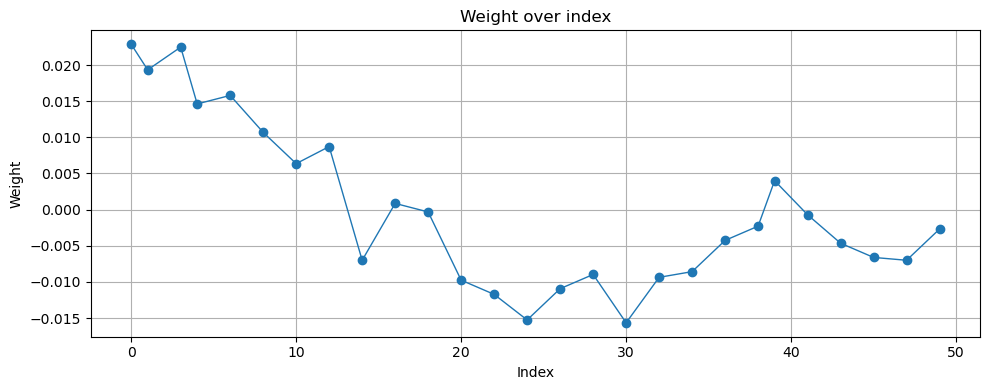

Now plotting: ECW/TBW


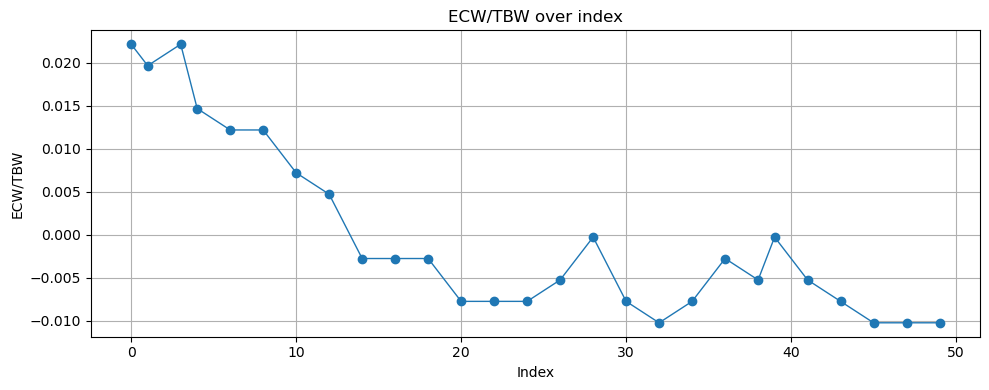

Now plotting: BMR (Basal Metabolic Rate)


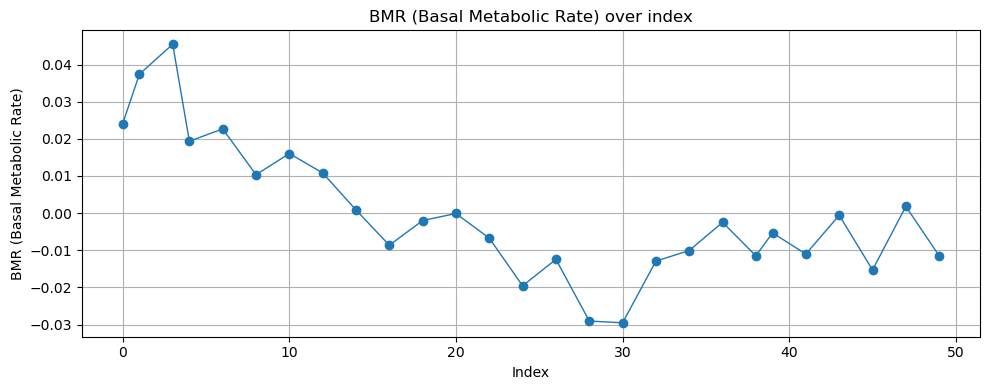

Now plotting: SMM (Skeletal Muscle Mass)


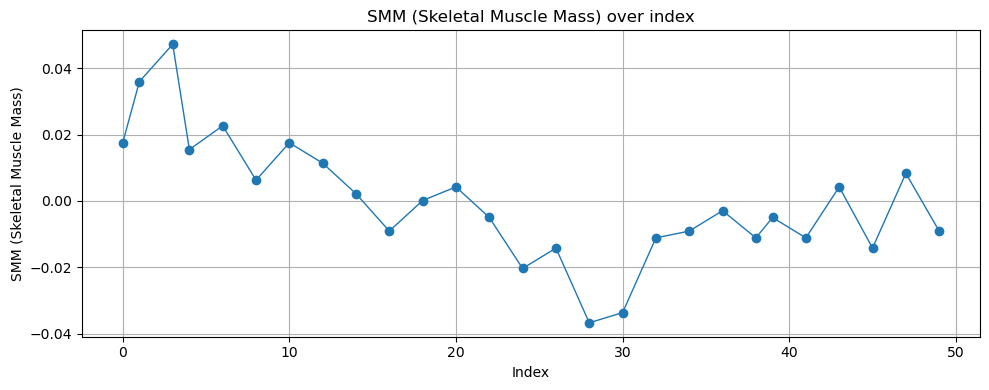

Now plotting: VFA (Visceral Fat Area)


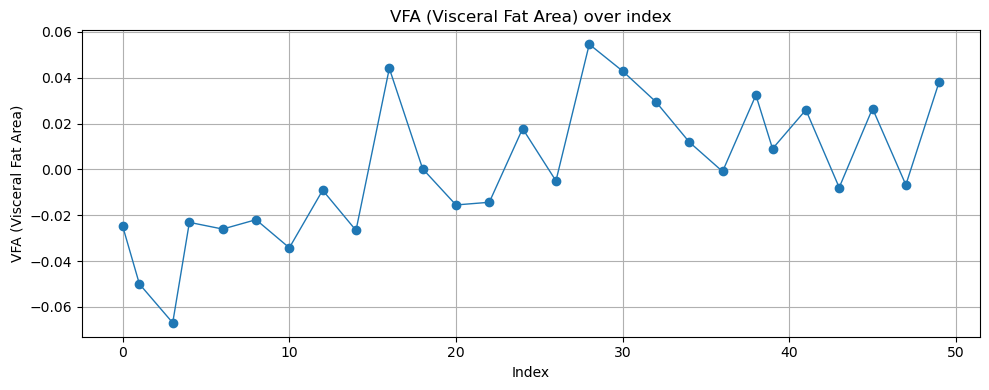

In [140]:
for plt_col in plt_lst:
    print("Now plotting:", plt_col)
    df_mf_ib77_nn_s_mrn_n0[plt_col]  =   scale_mean_to_one(df_mf_ib77_nn_s_mrn[plt_col])-1
    plot_column(df_mf_ib77_nn_s_mrn_n0, plt_col)

In [141]:
# plot_column(df_mf_ib77_nn_s_n0, "ECW/TBW")

# WORKING cell 